# Variational AutoEncoders on CelebA

In [1]:
import os
import time
from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as Transform
from torchsummary import summary

from matplotlib import pyplot as plt


## 0. Train Parameters

In [2]:
DATA_DIR = '../../data/CelebFaces/img_align_celeba/img_align_celeba/'
DATA_FOlDER = '../../data/CelebFaces/'
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 64
EMBEDDING_DIM = 200
LEARNING_RATE = 1e-3
EPOCHS = 15
BETA = 3.0

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


## 1. Prepare dataset

In [3]:
class CelebA(Dataset):
    def __init__(self, image_dir):
        super().__init__()

        self.transform = Transform.Compose([
                 Transform.ToTensor(),
                 Transform.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=True)
        ])

        self.dir = image_dir
        self.imgs = os.listdir(image_dir)
        self.length = len(self.imgs)

    def __len__(self):
        return self.length

    def __getitem__(self, i):
        output_img = self.transform(Image.open(self.dir + self.imgs[i]))
        return output_img

In [4]:
def get_dataloaders():
    celeb_a = CelebA(DATA_DIR)
    train_ds, test_ds = random_split(celeb_a, [0.8, 0.2])
    print('Train data size: {}'.format(len(train_ds)))
    print('Test data size: {}'.format(len(test_ds)))
    
    train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=8)
    test_loader = DataLoader(dataset=test_ds, batch_size=BATCH_SIZE,
                             shuffle=False, num_workers=8)
    return train_loader, test_loader

Train data size: 162080
Test data size: 40519
torch.Size([128, 3, 64, 64])


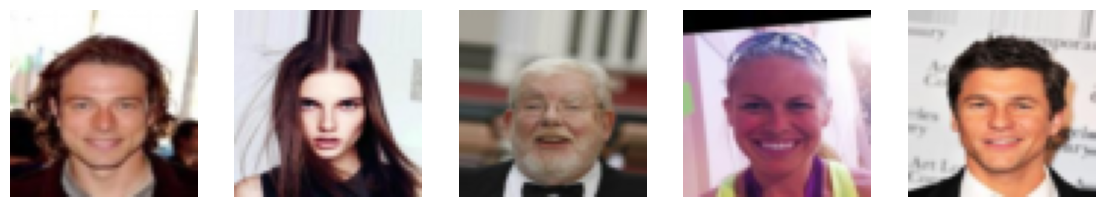

In [5]:
# Check dataset
check_ds, _ = get_dataloaders()
check_samples = next(iter(check_ds))
print(check_samples.shape)

plt.figure(figsize=(14, 3))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    img = check_samples[i].permute(1, 2, 0).clamp(0.0, 1.0)
    ax.imshow(img)
    ax.axis('off')

plt.show()

## 2. Building the Variational AutoEncoder

In [6]:
# Encoder
class Encoder(nn.Module):

    def __init__(self, latents, num_blocks=5):
        super().__init__()
        self.conv_module = nn.ModuleList()

        # Adding convolutional blocks to the module list
        for i in range(num_blocks):
            in_chan = 3 if i == 0 else NUM_FEATURES
            out_chan = NUM_FEATURES
            conv_block = nn.Sequential(
                nn.Conv2d(in_channels=in_chan,
                          out_channels=out_chan,
                          kernel_size=3,
                          stride=2,
                          padding=1),
                nn.BatchNorm2d(num_features=NUM_FEATURES),
                nn.LeakyReLU()
            )
            self.conv_module.append(conv_block)

        # Mapping features to mean and logvar
        self.mean = nn.Linear(in_features=256, out_features=EMBEDDING_DIM)
        self.logvar = nn.Linear(in_features=256, out_features=EMBEDDING_DIM)
        
    def forward(self, x):
        for module in self.conv_module:
            x = module(x)
        x = x.reshape(x.shape[0], -1)
        mean_x = self.mean(x)
        logvar_x = self.logvar(x)
        return mean_x, logvar_x

# encoder = Encoder(latents=EMBEDDING_DIM).to(DEVICE)
# summary(encoder, (3, 64, 64))


# # Decoder
class Decoder(nn.Module):

    def __init__(self, latents, num_blocks=5):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(in_features=EMBEDDING_DIM, out_features=256),
            nn.BatchNorm1d(num_features=256),
            nn.LeakyReLU()
        )
        
        self.trans_conv_module = nn.ModuleList()
        for _ in range(num_blocks):
            trans_conv = nn.Sequential(
                nn.ConvTranspose2d(in_channels=NUM_FEATURES, out_channels=NUM_FEATURES,
                                   kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.BatchNorm2d(num_features=NUM_FEATURES),
                nn.LeakyReLU()
            )
            self.trans_conv_module.append(trans_conv)

        self.output = nn.Sequential(
                            nn.Conv2d(in_channels=NUM_FEATURES,
                                      out_channels=3,
                                      kernel_size=3,
                                      padding=1),
                            nn.Sigmoid()
                            )

    def forward(self, x):
        x = self.fc(x)
        x = x.reshape(x.shape[0], 64, 2, 2)
        for module in self.trans_conv_module:
            x = module(x)
        return self.output(x)

# decoder = Decoder(latents=EMBEDDING_DIM).to(DEVICE)
# summary(decoder, (EMBEDDING_DIM,))

In [7]:
# Variational AutoEncoder
class VAE(nn.Module):
    def __init__(self, latents):
        super().__init__()
        self.encoder = Encoder(latents)
        self.decoder = Decoder(latents)

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        recon_x = self.decoder(z)
        return recon_x, mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar).to(DEVICE)
        eps = torch.randn(size=logvar.shape).to(DEVICE)
        return mean + std * eps

vae = VAE(EMBEDDING_DIM).to(DEVICE)
summary(vae, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 16, 16]          36,928
       BatchNorm2d-5           [-1, 64, 16, 16]             128
         LeakyReLU-6           [-1, 64, 16, 16]               0
            Conv2d-7             [-1, 64, 8, 8]          36,928
       BatchNorm2d-8             [-1, 64, 8, 8]             128
         LeakyReLU-9             [-1, 64, 8, 8]               0
           Conv2d-10             [-1, 64, 4, 4]          36,928
      BatchNorm2d-11             [-1, 64, 4, 4]             128
        LeakyReLU-12             [-1, 64, 4, 4]               0
           Conv2d-13             [-1, 64, 2, 2]          36,928
      BatchNorm2d-14             [-1, 6

## 3. Define the model, objective, and optimzer

In [8]:
def kl_divergence(mean, logvar):
    loss = -0.5 * (1 + logvar - torch.square(mean) -  torch.exp(logvar)).sum(axis=1)
    return loss.mean()

vae = VAE(EMBEDDING_DIM).to(DEVICE)

if torch.__version__.split('.')[0] == '2':
    torch.set_float32_matmul_precision('high')
    vae = torch.compile(vae) # PyTorch 2.0 feature
    print('model compiled')

mse_loss_fn = nn.MSELoss(reduction='sum')
kl_loss_fn = kl_divergence
optim = torch.optim.AdamW(vae.parameters(), lr=LEARNING_RATE)

model compiled


## 4. Get dataloaders

In [9]:
train_loader, test_loader = get_dataloaders()

Train data size: 162080
Test data size: 40519


In [10]:
# A single epoch train funcion
def train(model, dataloader, optimizer, mse_loss_fn, kl_loss_fn):

    model.train()
    running_mse_loss = 0
    running_kl_loss = 0

    for i, train_x in enumerate(dataloader):
        optimizer.zero_grad()
        train_x = train_x.to(DEVICE)
        recon_x, mean, logvar = model(train_x)
        mse_loss = mse_loss_fn(recon_x, train_x) / BATCH_SIZE
        kl_loss = kl_loss_fn(mean, logvar)
        loss = mse_loss + BETA * kl_loss
        loss.backward()
        optimizer.step()

        running_mse_loss += mse_loss.item()
        running_kl_loss += kl_loss.item()

        del train_x, recon_x
        torch.cuda.empty_cache()

    return running_mse_loss / len(dataloader), running_kl_loss / len(dataloader)

# Validation function
def validate(model, dataloader, mse_loss_fn, kl_loss_fn):
    
    model.eval()
    running_mse_loss = 0
    running_kl_loss = 0
    
    for i, test_x in enumerate(dataloader):
        test_x = test_x.to(DEVICE)
        with torch.no_grad():
            recon_x, mean, logvar = model(test_x)
            mse_loss = mse_loss_fn(recon_x, test_x) / BATCH_SIZE
            kl_loss = kl_loss_fn(mean, logvar)

        running_mse_loss += mse_loss.item()
        running_kl_loss += kl_loss.item()
        
        del test_x, recon_x
        torch.cuda.empty_cache()

    return running_mse_loss / len(dataloader), running_kl_loss / len(dataloader)

## Train and evaluate

In [ ]:
for i in range(EPOCHS):
    prev_time = time.time()
    train_mse_loss, train_kl_loss = train(vae, train_loader, optim, mse_loss_fn, kl_loss_fn)
    test_mse_loss, test_kl_loss = validate(vae, test_loader, mse_loss_fn, kl_loss_fn)

    curr_time = time.time()
    print('Epoch: {}\tepoch time {:.2f} min'.format(
        i + 1, (curr_time - prev_time) / 60
    ))
    
    print(f'\tTrain - mse_loss: {train_mse_loss:.4f}, kl_loss: {train_kl_loss:.4f}')
    print(f'\tValid - mse_loss: {test_mse_loss:.4f}, kl_loss: {test_kl_loss:.4f}')

[2023-06-11 11:36:37,484] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-06-11 11:37:33,442] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-06-11 11:37:36,542] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-06-11 11:37:46,877] torch._inductor.utils: [WARNING] using triton random, expect difference from eager


Epoch: 1	epoch time 1.23 min
	Train - mse_loss: 267.5043, kl_loss: 3.2174
	Valid - mse_loss: 199.8909, kl_loss: 2.2821
Epoch: 2	epoch time 1.05 min
	Train - mse_loss: 183.0731, kl_loss: 1.8829
	Valid - mse_loss: 167.2675, kl_loss: 1.5623
Epoch: 3	epoch time 1.04 min
	Train - mse_loss: 163.5408, kl_loss: 1.6028
	Valid - mse_loss: 156.9446, kl_loss: 1.5808
Epoch: 4	epoch time 1.03 min
	Train - mse_loss: 151.6878, kl_loss: 1.4399
	Valid - mse_loss: 149.7332, kl_loss: 1.5138
Epoch: 5	epoch time 1.07 min
	Train - mse_loss: 144.5642, kl_loss: 1.3692
	Valid - mse_loss: 146.6057, kl_loss: 1.3972
Epoch: 6	epoch time 1.08 min
	Train - mse_loss: 138.4757, kl_loss: 1.3031
	Valid - mse_loss: 145.0434, kl_loss: 1.2833
Epoch: 7	epoch time 1.06 min
	Train - mse_loss: 133.2446, kl_loss: 1.2447
	Valid - mse_loss: 131.5697, kl_loss: 1.2207
Epoch: 8	epoch time 1.07 min
	Train - mse_loss: 129.5159, kl_loss: 1.2098
	Valid - mse_loss: 129.5399, kl_loss: 1.3688
Epoch: 9	epoch time 1.06 min
	Train - mse_loss: 